In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from os.path import join
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [5]:
import sys; sys.path.append("../")

from utils import load_json

In [14]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

#### Plot `ResNet18` results

In [54]:
def plot_corruption_results(model_name, model_results, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.axhline(y=model_results["clean"], label=f"Clean [ {model_results['clean']:.4f} ]")

    severity_values = [1, 2, 3, 4, 5]
    corruption_wise_results = defaultdict(list)
    for key, top1 in model_results.items():
        if key != "clean":
            corruption, severity = key.split("_transform_")
            corruption_wise_results[corruption].append(top1)

    for corruption, values in corruption_wise_results.items():
        ax.plot(severity_values, values, "--o", label=corruption.replace("_", " ").capitalize())

    ax.set_title(f"{model_name.upper()}: Top-1 accuracy vs Severity of corruption", fontsize=20)
    ax.grid()
    ax.legend(fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_ylim(0.2, 1.0)

    plt.savefig(f"../results/{model_name}_top1_vs_severity.png", bbox_inches="tight")
    plt.show()

In [22]:
path = "../results/resnet18_results.json"

In [23]:
results = load_json(path)

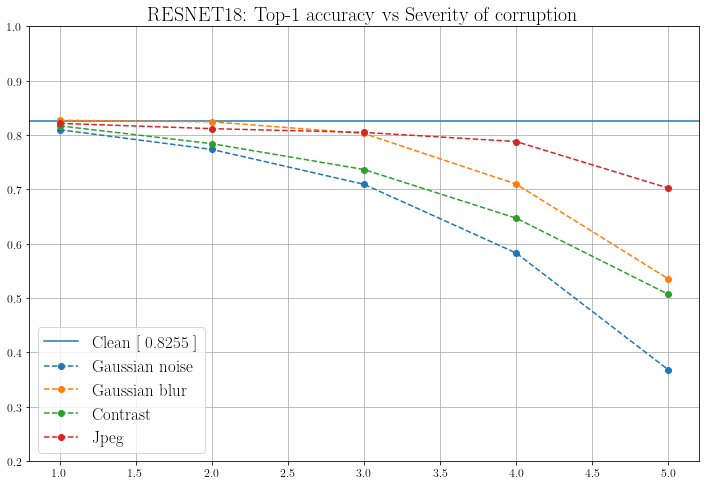

In [55]:
plot_corruption_results("resnet18", results)

### Computing `CE` and `RCE` for various models

In [56]:
def get_corruption_wise_results(results):
    corruption_wise_results = defaultdict(list)
    for key, top1 in results.items():
        if key != "clean":
            corruption, severity = key.split("_transform_")
            corruption_wise_results[corruption].append(top1)
    return corruption_wise_results


def compute_corruption_error(model_name, model_results, resnet18_results):
    model_corruption_results = get_corruption_wise_results(model_results)
    resnet18_corruption_results = get_corruption_wise_results(resnet18_results)
    
    model_corruption_errors = {k:np.mean(v) for k, v in model_corruption_results.items()}
    resnet18_corruption_errors = {k:np.mean(v) for k, v in resnet18_corruption_results.items()}
    
    return {k: model_corruption_errors[k]/resnet18_corruption_errors[k] for k in model_corruption_errors}


def compute_relative_corruption_error(model_name, model_results, resnet18_results):
    model_corruption_results = get_corruption_wise_results(model_results)
    resnet18_corruption_results = get_corruption_wise_results(resnet18_results)
    
    mce = {k:np.mean(v) for k, v in model_corruption_results.items()}
    rce = {k:np.mean(v) for k, v in resnet18_corruption_results.items()}
    
    return {
        k: (mce[k] - model_results["clean"])/(rce[k] - resnet18_results["clean"]) for k in mce
    }

In [57]:
compute_corruption_error("resnet18", results, results)

{'gaussian_noise': 1.0, 'gaussian_blur': 1.0, 'contrast': 1.0, 'jpeg': 1.0}

In [58]:
compute_relative_corruption_error("resnet18", results, results)

{'gaussian_noise': 1.0, 'gaussian_blur': 1.0, 'contrast': 1.0, 'jpeg': 1.0}

### Show results for all models

resnet18


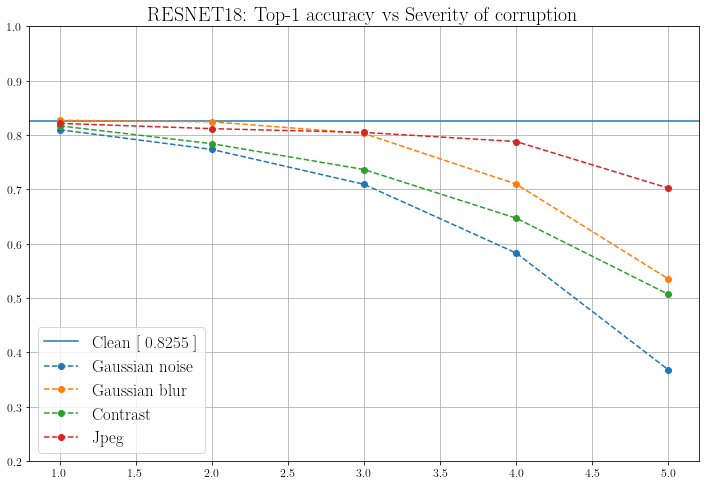

CE
{'gaussian_noise': 1.0, 'gaussian_blur': 1.0, 'contrast': 1.0, 'jpeg': 1.0}
RCE
{'gaussian_noise': 1.0, 'gaussian_blur': 1.0, 'contrast': 1.0, 'jpeg': 1.0}
resnet34


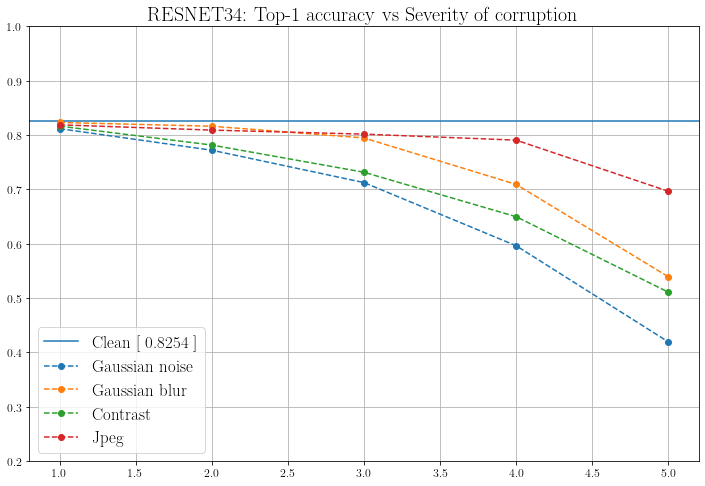

CE
{'gaussian_noise': 1.0210359472157347, 'gaussian_blur': 0.9953753222363474, 'contrast': 0.9995468402309168, 'jpeg': 0.997004172529379}
RCE
{'gaussian_noise': 0.9222072489922585, 'gaussian_blur': 1.0388258882621728, 'contrast': 1.0017111664971239, 'jpeg': 1.0566318606810425}


In [61]:
model_names = ["resnet18", "resnet34"]
for model_name in model_names:
    print(model_name)
    path = f"../results/{model_name}_results.json"
    model_results = load_json(path)
    plot_corruption_results(model_name, model_results)
    print("CE")
    print(compute_corruption_error(model_name, model_results, results))
    print("RCE")
    print(compute_relative_corruption_error(model_name, model_results, results))